# 4.6 FIR filters and oversampling

## 4.6.1 Averaging

The acronym FIR stands for finite impulse response  
In this type of filter, the output is computed only from the input  
or previous values of the input  
  
Very often, when one first encounters a noisy signal, they want to average to remove the noise  
The moving average is a FIR filter  
Let's design a filter where the output is the average of the  
current sample and the 4 previous samples  
  
$$Y_k=\frac{X_k+X_{k-1}+X_{k-2}+X_{k-3}+X_{k-4}}{5}$$  
You can see that no previous values of the output  
are used to compute the current value of the output  
  
The FIR filter has no continuous time counterpart  
it is an inherently discrete time construct  
  
We can find the transfer function for the filter,  
by doing the steps to find the difference equation in reverse  
First, assume $X(z)$ represents the current sample,  
and $X(z)z^{-1}$ represents the previous sample  
  
$$Y(z)=\frac{X(z)+X(z)z^{-1}+X(z)z^{-2}+X(z)z^{-3}+X(z)z^{-4}}{5}$$  
solve for the transfer function  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{1+z^{-1}+z^{-2}+z^{-3}+z^{-4}}{5}$$  
multiply by $\frac{z^4}{z^4}$ and $\frac{0.2}{0.2}$  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{0.2z^4+0.2z^3+0.2z^2+0.2z+0.2}{z^4}$$  
The code cell below creates a dlti object for the filter  
and plots the unit step response  
You can see the moving average FIR filter does not have an exponential response  
like the IIR or continuous time filters  
The response is really just the moving average  

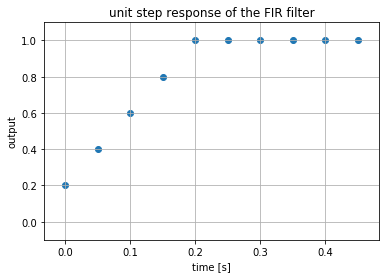

In [1]:
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np

num = [0.2, 0.2, 0.2, 0.2, 0.2]
den = [1, 0, 0, 0, 0] # don't forget the zeros

H_z = sig.dlti(num, den, dt=0.05)

# Make a short time array so you can see the first few points
t = np.arange(0, 0.5, 0.05)
t, y_t = H_z.step(t=t)

plt.scatter(t, np.squeeze(y_t))
plt.ylim([-0.1, 1.1])
plt.xlabel('time [s]')
plt.ylabel('output')
plt.title('unit step response of the FIR filter')
plt.grid()

## 4.6.2 Creating a Bode plot of the FIR filter

The Bode plot for the FIR filter can be calculated  
for frequencies between 0 and half the sampling rate  

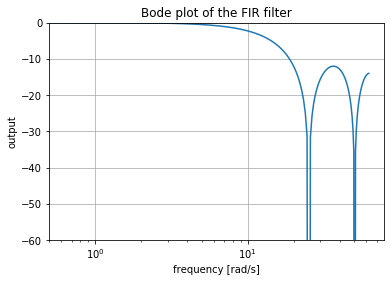

In [2]:
w, mag, phase = H_z.bode()

plt.plot(w, mag)
plt.xscale('log')
plt.ylim([-60, 0])
plt.xlabel('frequency [rad/s]')
plt.ylabel('output')
plt.title('Bode plot of the FIR filter')
plt.grid()

You can see the moving average is a low-pass filter  
and this one has zeros at 1/5 and 2/5 of the sampling rate  
(There are actually zeros at 3/5, and 4/5 of the sampling rate,  
but these are beyond the Nyquist-Shannon sampling limit)  
The poles are all at $z=0$  
  
The code cell below plots the poles and zeros on the z-plane  

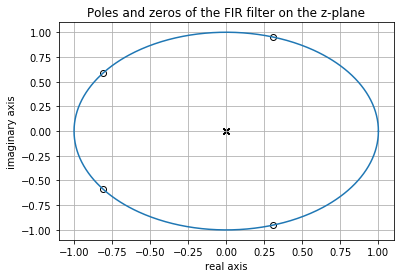

In [3]:
plt.scatter(H_z.poles.real, H_z.poles.imag, marker='x', color='k')
plt.plot(H_z.zeros.real, H_z.zeros.imag, marker='o', color='k', fillstyle='none', linestyle='none')

r = []
i = []
# plot the unit circle
for theta in np.arange(0, 2*np.pi, 0.01):
    r.append(np.exp(1j*theta).real)
    i.append(np.exp(1j*theta).imag)
plt.plot(r, i)
plt.xlabel('real axis')
plt.ylabel('imaginary axis')
plt.title('Poles and zeros of the FIR filter on the z-plane')
plt.grid()

## 4.6.3 Implementing a FIR filter in real time

The FIR filter can be implemented in real time,  
just like an IIR filter, using the difference equation  
  
We will assume a sampling rate of 20 sample/sec and    
the same noisy sine wave used in the previous section  
  
the code cell below implements the filter in real time

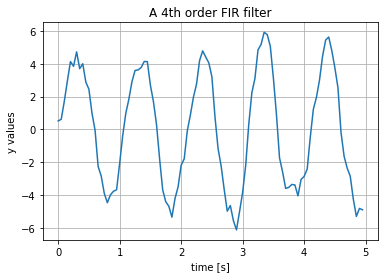

In [4]:
# create a sine wave signal sampled at 2000 samples/sec
t = np.linspace(0, 5, 10000)

# 1 Hz sine wave with amplitude of 5
A = -5j
s = 1j*2*np.pi*1
x_clean_t = (A/2)*np.exp(s*t)+(np.conjugate(A)/2)*np.exp(np.conjugate(s)*t)

# create noise 
x_noise_t = np.random.normal(0, 2, 10000)

# create a noisy input signal at 2000 samples/sec
x_t = (x_clean_t + x_noise_t).real

# read the signal at 20 samples/sec (every 100th point)
analogRead = x_t[::100]
analogWrite = []

x_k1 = 0
x_k2 = 0
x_k3 = 0
x_k4 = 0

for k in range(len(analogRead)):
    x_k = analogRead[k] # read the value from the ADC unit
    
    y_k = 0.2*x_k
    y_k = y_k + 0.2*x_k1
    y_k = y_k + 0.2*x_k2
    y_k = y_k + 0.2*x_k3
    y_k = y_k + 0.2*x_k4

    analogWrite.append(y_k) 
    
    # this pipeline is 4 elements deep
    x_k4 = x_k3
    x_k3 = x_k2
    x_k2 = x_k1
    x_k1 = x_k
    
    # delay(50)
    
plt.plot(t[::100], analogWrite)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('A 4th order FIR filter')
plt.grid()

## 4.6.4 Anti-alaising

In all of the digital filter examples we have seen so far,  
the noise we introduced into the signal has frequency components  
higher than the Nyquist-Shannon sampling limit  
  
That noise is aliased to lower frequencies and therefore,  
cannot be removed by the low pass filter  
  
The proper way to design digital sampling systems,  
is to include an anti-aliasing filter to prevent any signals  
with frequencies greater than half the sampling rate from getting into the ADC  
  
If you are using a 10-bit ADC, then you would like the anti-aliasing filter to suppress  
frequencies at or above half the sampling rate by at least 60 dB, 6 dB/bit  
  
A first-order filter reduces signals above its cut-frequency at 20 dB/decade,  
therefore, a first-order anti-aliasing filter would need to have a  
cut-off frequency 3 decades below half the sampling rate  
In our example, half the sampling rate is 10Hz, or 62.8[rad/s],  
so 3 decades below that is 0.01Hz, but the sine wave that we want to pass is a 1Hz sine wave  
1Hz would not be able to get through that anti-aliasing filter  
  
If we want to allow our 1Hz sine wave to pass and provide the proper amount of anti-aliasing  
we would need a $3^{rd}$ order anti-aliasing filter,  
which can reduce signals above the cut-frequency at 60 dB/decade  
The $3^{rd}$ order filter could have a cut-off frequency of 1Hz  
  
The diagram below shows the required system  
![image1!](./images_s4/image_4_6_1.png)  
The code cell below computes the output of this system,  
using the same real-time 4th order FIR filter in the Arduino

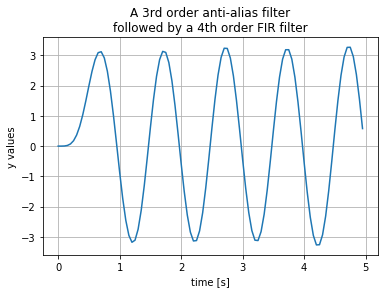

In [5]:
# create a output signal from the continuous time anti-aliasing filter
num, den = sig.butter(3, 2*np.pi*1, analog=True)
anti_alias = sig.lti(num, den)
t_filtered, x_filtered_t, xout = anti_alias.output(x_t, t)

# read the signal at 20 samples/sec (every 100th point)
analogRead = x_filtered_t[::100]

analogWrite = []

x_k1 = 0
x_k2 = 0
x_k3 = 0
x_k4 = 0

for k in range(len(analogRead)):
    x_k = analogRead[k] # read the value from the ADC unit
    
    y_k = 0.2*x_k
    y_k = y_k + 0.2*x_k1
    y_k = y_k + 0.2*x_k2
    y_k = y_k + 0.2*x_k3
    y_k = y_k + 0.2*x_k4

    analogWrite.append(y_k) 
    
    # this pipeline is 4 elements deep
    x_k4 = x_k3
    x_k3 = x_k2
    x_k2 = x_k1
    x_k1 = x_k
    
    # delay(50)

plt.plot(t[::100], analogWrite)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('A 3rd order anti-alias filter\nfollowed by a 4th order FIR filter')
plt.grid()

So you can see this system works great, but it is a lot of circuit to build!  
Nobody wants to build that, it adds cost and reliability isses  

## 4.6.5 Oversampling

Oversampling simply means sampling at a rate above the Nyquist-Shannon sampling limit  
  
In our system we have been sampling at 20 samples/sec,  
However, if the Arduino can do it, we could sample at 2000 samples/sec,  
way above the Shannon-Nyquist sampling limit!  
  
What this does, is it changes the requirements for the anti-aliasing filter  
Now we need a drop of 60dB at a frequency of 1000Hz, rather than 10Hz  
A simple first order RC filter with a cut-off frequency of 1Hz can do that  
so it reduces the amount of circuitry required for anti-aliasing  
  
The diagram below shows the simplified system  
![image2!](./images_s4/image_4_6_2.png)  

## 4.6.6 Decimation

A problem with oversampling is that it generates a LOT more data  
We have increased the sampling rate by 100 times, so there are 100 times as many data points  
If we wanted to save this to a file, the file would quickly become huge  
  
If we want to reduce the amount of data, we could just through away samples,  
but that is no different than reducing the sampling rate, you will get aliasing again  
  
The solution is to oversample and then use a digital filter to perform anti-aliasing  
when that is done, then then you can throw away the samples  
This process is known as decimation  
  
In our previous example, we used a $3^{rd}$ order anti-aliasing filter,  
and now we are using a $1^{st}$ order  
We can just implement the other two orders as a digital filter  
and then reduce the data by a factor of 100  
We will have prevented aliasing just as we did in the previous example  
  
Think of oversampling as trading circuitry for code  
You need a fast enough Arduino to do it, but if you can, it will be a lot more reliable  
  
Let's design our decimation (anti-aliasing) filter  
as a 2nd order Butterworth and then find the difference equation  
remember, Scipy requires a normalized frequency for the cut-off frequency  
of discrete time filters, $\frac{cut-off}{half\;sampling\;rate}=\frac{1Hz}{1000Hz}$

In [6]:
num, den = sig.butter(2, 0.001)
print('num =', num)
print('den =', den)

num = [2.46193005e-06 4.92386009e-06 2.46193005e-06]
den = [ 1.         -1.99555712  0.99556697]


The coefficients are very small and therefore could cause rounding error  
often decimation filters are performed in stages, so each stage has larger coefficients  
but we will try it with one stage  
  
The transfer function is  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{2.46\cdot10^{-6}z^2+4.92\cdot10^{-6}z+2.46\cdot10^{-6}}{z^2-1.99z+0.99}$$  
multiply by $\frac{z^{-2}}{z^{-2}}$  
  
$$H(z)=\frac{Y(z)}{X(z)}=\frac{2.46\cdot10^{-6}+4.92\cdot10^{-6}z^{-1}+2.46\cdot10^{-6}z^{-2}}{1-1.99z^{-1}+0.99z^{-2}}$$  
cross multiply  
  
$$Y(z)(1-1.99z^{-1}+0.99z^{-2})=X(z)(2.46\cdot10^{-6}+4.92\cdot10^{-6}z^{-1}+2.46\cdot10^{-6}z^{-2})$$  
distribute the terms, identify $z^{-1}$ as a unit time delay, and solve for the current output sample  
  
$$Y_k=1.99Y_{k-1}-0.99Y_{k-2}+2.46\cdot10^{-6}X_k+4.92\cdot10^{-6}X_{k-1}+2.46\cdot10^{-6}X_{k-2}$$  
The code cell below implements a second order butterworth filter at 2000 samples/sec  
and then reduces the sampling rate to 20 samples/sec, so it can apply the 4th order FIR filter  
  
The code does this as a real-time Arduino filtering application,  
However, you could easily write the data to a file rather than the DAC  

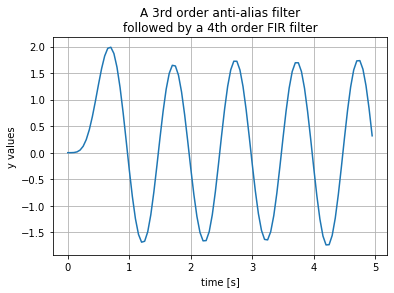

In [7]:
# create a signal from the 1st order continuous time anti-aliasing filter
num, den = sig.butter(1, 2*np.pi*1, analog=True)
anti_alias = sig.lti(num, den)
t_filtered, x_filtered_t, xout = anti_alias.output(x_t, t)

# read the signal at 2000 samples/sec
analogRead = x_filtered_t

analogWrite = []

# set up the decimation filter
x_decimation_k1 = 0
x_decimation_k2 = 0
y_decimation_k1 = 0
y_decimation_k2 = 0

# set up the FIR filter
x_k1 = 0
x_k2 = 0
x_k3 = 0
x_k4 = 0
        

for k in range(len(analogRead)):
    x_decimation_k = analogRead[k] # read the value from the ADC unit
    
    y_decimation_k = 1.99555712*y_decimation_k1
    y_decimation_k = y_decimation_k - 0.99556697*y_decimation_k2
    y_decimationf_k = y_decimation_k + 2.46193005e-06*x_decimation_k
    y_decimation_k = y_decimation_k + 4.92386009e-06*x_decimation_k1
    y_decimation_k = y_decimation_k + 2.46193005e-06*x_decimation_k2
    
    # every 100th sample, perform the FIR filter code
    if k/100 == int(k/100):
        
        x_k = y_decimation_k # the FIR filter sees the output from the decimation filter
        
        y_k = 0.2*x_k
        y_k = y_k + 0.2*x_k1
        y_k = y_k + 0.2*x_k2
        y_k = y_k + 0.2*x_k3
        y_k = y_k + 0.2*x_k4
        
        analogWrite.append(y_k)
        
        # this pipeline is 4 elements deep
        x_k4 = x_k3
        x_k3 = x_k2
        x_k2 = x_k1
        x_k1 = x_k

    # the decimation filter is a 2nd order IIR filter, 
    # so it has 2 piplelines, each 2 elements deep
    x_decimation_k2 = x_decimation_k1
    x_decimation_k1 = x_decimation_k
    y_decimation_k2 = y_decimation_k1
    y_decimation_k1 = y_decimation_k
    
    # the decimation filter samples at 2000 samples/sec
    # and therfore needs a delay of 1/2000 = 500 microseconds
    # delayMicroseconds(500)

plt.plot(t[::100], analogWrite)
plt.xlabel('time [s]')
plt.ylabel('y values')
plt.title('A 3rd order anti-alias filter\nfollowed by a 4th order FIR filter')
plt.grid()

We see the same result we achieved with the 3rd order continuous time analog anti-aliasing filter!  
Employing proper anti-aliasing techniques is very important to measuring good data  
  
For our example, as long as the Arduino is fast enough to do all the math,  
and perform the analog to digital convertion within 500 microsends,  
then you trade a lot of circuitry for code  
  
By filtering using the decimation technique, we can reduce the amount of data considerably  
In the code cell below, let's look at the length of the analogWrite array,  
just to make sure we have reduced the sample rate to 20 samples/sec  

In [8]:
print('the number of samples in 5 seconds worth of measurements =', len(analogWrite))
print('which is', len(analogWrite)/5, 'samples/sec')

the number of samples in 5 seconds worth of measurements = 100
which is 20.0 samples/sec
